In [24]:
#import the library
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import seaborn as sns
import rpy2.rinterface_lib.callbacks
import logging
import os
from rpy2.robjects import pandas2ri
import anndata2ri
from adjustText import adjust_text
import matplotlib.patheffects as pe
import importlib
import warnings
warnings.filterwarnings("ignore")
import glob
import pickle as pkl
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from matplotlib.colors import LinearSegmentedColormap
values = [0,1]
colors = [(227, 227, 227), (255, 42, 18)]
norm = plt.Normalize(min(values), max(values))
my_cmap = LinearSegmentedColormap.from_list(
    '', [(norm(value), tuple(np.array(color) / 255)) for value, color in zip(values, colors)])

In [13]:
def get_df_from_rank(adata, rank_key,celltype):
        df = pd.DataFrame(index = adata.uns[rank_key]['names'][celltype], columns = ['log2fold','pval_adj'])
        df['log2fold'] = adata.uns[rank_key]['logfoldchanges'][celltype].astype('double')
        df['pval_adj'] = adata.uns[rank_key]['pvals_adj'][celltype].astype('double')
        return df

In [3]:
wd = r'F:\gdT_aim2\NicheNet'
os.chdir(wd)

In [12]:
adata = sc.read_h5ad(r"F:\gdT_aim2\organized_data\unimputed\gdT_integrated.h5ad")
# adata = sc.read_h5ad(r"F:\gdT_aim2\Geneformer\geneformer_gdT_canceronly_high_low_act_2_cancer_only.h5ad")

In [19]:
general_type = adata.obs['cell type'].astype(str)
general_type = general_type.replace({r'IL7R.* TRM':'TRM', r'^.*Teff.*':'Teff','^.*Tex.*':'Tex'},regex=True)
adata.obs['general type'] = general_type

In [20]:
adata_tumor = adata[adata.obs['tissue']=='Carcinoma']

In [ ]:
#For Teff to Tex
sc.tl.rank_genes_groups(adata_tumor, groupby = 'general type', groups = ['Teff','Tex'], reference= 'Teff', key_added= 'Teff2Tex',method = 'wilcoxon')
deg_df  = get_df_from_rank(adata_tumor, rank_key='Teff2Tex',celltype='Tex')
deg_df_sig = deg_df[(deg_df['pval_adj']<0.05) & (abs(deg_df['log2fold'])>1)]
deg_df_sig.to_csv('Teff2Tex_deg.csv')
# deg_df_sig = deg_df[(deg_df['pval_adj']<0.05) & (deg_df['log2fold']>1)]
# deg_df_sig.to_csv('Teff2Tex_up.csv')

In [ ]:
deg_df['-log10(Padj)'] = -np.log10(deg_df['pval_adj'])
deg_df = deg_df[deg_df['-log10(Padj)']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = deg_df[np.array(deg_df['-log10(Padj)']>=-np.log10(0.05)) & np.array(abs(deg_df['log2fold'])>=fc_thresh)]
other_de = deg_df[np.array(deg_df['-log10(Padj)']<-np.log10(0.05)) | np.array(abs(deg_df['log2fold'])<fc_thresh)] #actually that's other genes (non sig de)

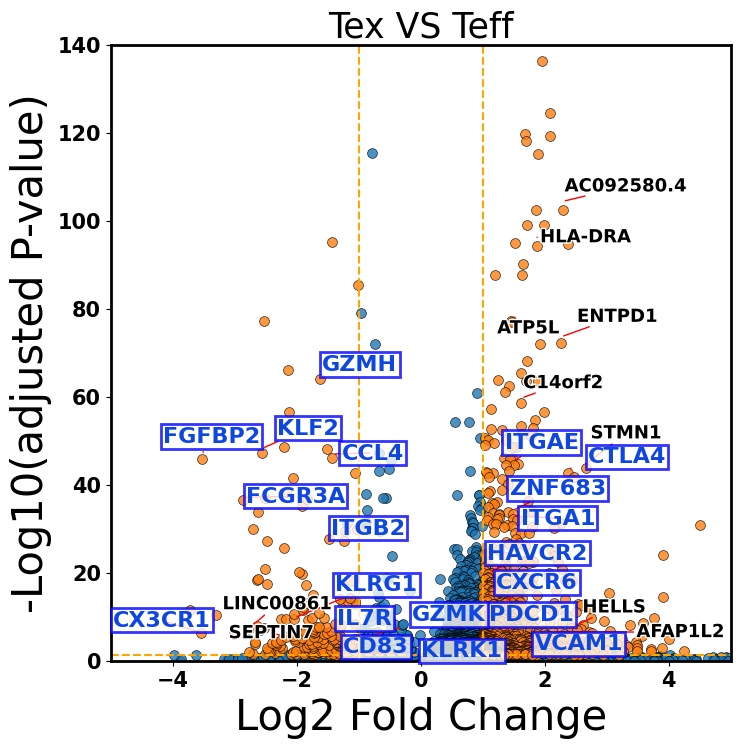

In [12]:
# Volcano plot of results
fig, ax = plt.subplots()
sb.regplot(other_de['log2fold'], other_de['-log10(Padj)'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['log2fold'], lowqval_de['-log10(Padj)'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Log2 Fold Change", fontsize=30)
ax.set_ylabel("-Log10(adjusted P-value)", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('Tex VS Teff',size = 25)
    
# Label names and positions
x = [i for i in lowqval_de['log2fold']]
y = [i*1.02 for i in lowqval_de['-log10(Padj)']]
labels = lowqval_de.index
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de.index.str.startswith('RP'))
                    |np.array(lowqval_de.index.str.startswith('MT'))
                    |np.array(lowqval_de.index.str.startswith('IG'))
                     |(np.array(lowqval_de['log2fold']<fc_thresh*2)
                       &np.array(lowqval_de['log2fold']>0)
                           &np.array(lowqval_de['-log10(Padj)']<50))
                    |(np.array(abs(lowqval_de['log2fold'])<fc_thresh*2)
                      &np.array(lowqval_de['log2fold']<0)
                           &np.array(lowqval_de['-log10(Padj)']<50))
                   |np.array(lowqval_de['-log10(Padj)']<5))==0)

texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','CCL4','CCL5','CCL3','CX3CR1','CXCR3','CXCR6']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if txt in labels[to_keep]:
          if np.random.rand(1) >= 0.9:
               texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
plt.ylim([-0.01,140])
plt.xlim([-5,5])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('vis/Tex VS Teff.png')
#plt.show()

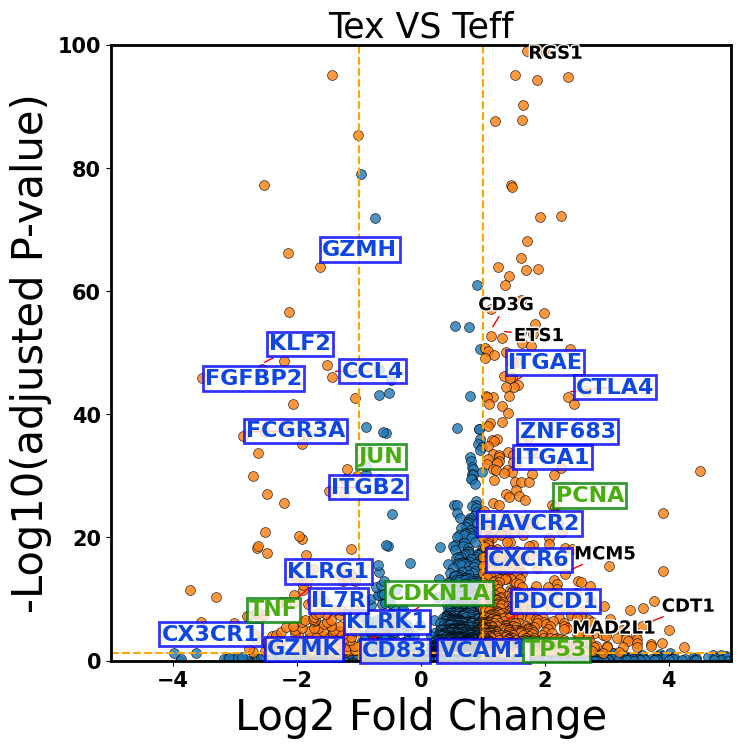

In [41]:
# Volcano plot of results
fig, ax = plt.subplots()
sb.regplot(other_de['log2fold'], other_de['-log10(Padj)'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['log2fold'], lowqval_de['-log10(Padj)'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Log2 Fold Change", fontsize=30)
ax.set_ylabel("-Log10(adjusted P-value)", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('Tex VS Teff',size = 25)
    
# Label names and positions
x = [i for i in lowqval_de['log2fold']]
y = [i*1.02 for i in lowqval_de['-log10(Padj)']]
labels = lowqval_de.index
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de.index.str.startswith('RP'))
                    |np.array(lowqval_de.index.str.startswith('MT'))
                    |np.array(lowqval_de.index.str.startswith('IG'))
                     |(np.array(lowqval_de['log2fold']<fc_thresh*2)
                       &np.array(lowqval_de['log2fold']>0)
                           &np.array(lowqval_de['-log10(Padj)']<50))
                    |(np.array(abs(lowqval_de['log2fold'])<fc_thresh*2)
                      &np.array(lowqval_de['log2fold']<0)
                           &np.array(lowqval_de['-log10(Padj)']<50))
                   |np.array(lowqval_de['-log10(Padj)']<5))==0)

texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','CCL4','CCL5','CCL3','CX3CR1','CXCR3','CXCR6']
nichenet_target = pd.read_csv('Teff2Tex_ligand_target.csv',index_col =0).values.flatten().tolist()
for i,txt in enumerate(labels):
    if txt not in important_list or txt not in nichenet_target:
        if txt in labels[to_keep]:
          if np.random.rand(1) >= 0.95:
               texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))

for i,txt in enumerate(labels):    
    if txt in nichenet_target:
        texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 16, color= '#49ad10', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="g", lw=2, alpha = 0.8)))

plt.ylim([-0.01,100])
plt.xlim([-5,5])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('vis/Tex VS Teff target highlight.png')
#plt.show()

In [21]:
sc.tl.rank_genes_groups(adata_tumor, groupby = 'general type', groups = ['TRM','Teff'], reference= 'TRM', key_added= 'TRM2Teff',method = 'wilcoxon')
deg_df  = get_df_from_rank(adata_tumor, rank_key='TRM2Teff',celltype='Teff')
deg_df_sig = deg_df[(deg_df['pval_adj']<0.05) & (abs(deg_df['log2fold'])>1)]
deg_df_sig.to_csv('TRM2Teff_deg.csv')
# deg_df_sig = deg_df[(deg_df['pval_adj']<0.05) & (deg_df['log2fold']>1)]
# deg_df_sig.to_csv('TRM2Teff_up.csv')

In [22]:
deg_df['-log10(Padj)'] = -np.log10(deg_df['pval_adj'])
deg_df = deg_df[deg_df['-log10(Padj)']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = deg_df[np.array(deg_df['-log10(Padj)']>=-np.log10(0.05)) & np.array(abs(deg_df['log2fold'])>=fc_thresh)]
other_de = deg_df[np.array(deg_df['-log10(Padj)']<-np.log10(0.05)) | np.array(abs(deg_df['log2fold'])<fc_thresh)] #actually that's other genes (non sig de)

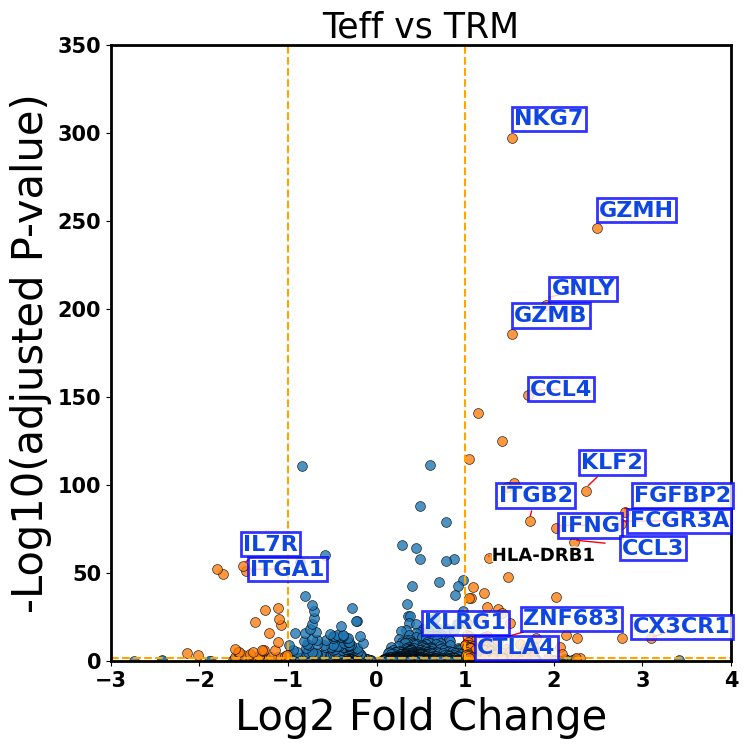

In [25]:
# Volcano plot of results
fig, ax = plt.subplots()
sb.regplot(other_de['log2fold'], other_de['-log10(Padj)'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['log2fold'], lowqval_de['-log10(Padj)'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Log2 Fold Change", fontsize=30)
ax.set_ylabel("-Log10(adjusted P-value)", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('Teff vs TRM',size = 25)
    
# Label names and positions
x = [i for i in lowqval_de['log2fold']]
y = [i*1.02 for i in lowqval_de['-log10(Padj)']]
labels = lowqval_de.index
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de.index.str.startswith('RP'))
                    |np.array(lowqval_de.index.str.startswith('MT'))
                    |np.array(lowqval_de.index.str.startswith('IG'))
                     |(np.array(lowqval_de['log2fold']<fc_thresh*2)
                       &np.array(lowqval_de['log2fold']>0)
                           &np.array(lowqval_de['-log10(Padj)']<50))
                    |(np.array(abs(lowqval_de['log2fold'])<fc_thresh*2)
                      &np.array(lowqval_de['log2fold']<0)
                           &np.array(lowqval_de['-log10(Padj)']<50))
                   |np.array(lowqval_de['-log10(Padj)']<5))==0)

texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','CCL4','CCL5','CCL3','CX3CR1','CXCR3','CXCR6']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if txt in labels[to_keep]:
          if np.random.rand(1) >= 0.9:
               texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
plt.ylim([-0.01,350])
plt.xlim([-3,4])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('vis/Teff vs TRM.png')
#plt.show()

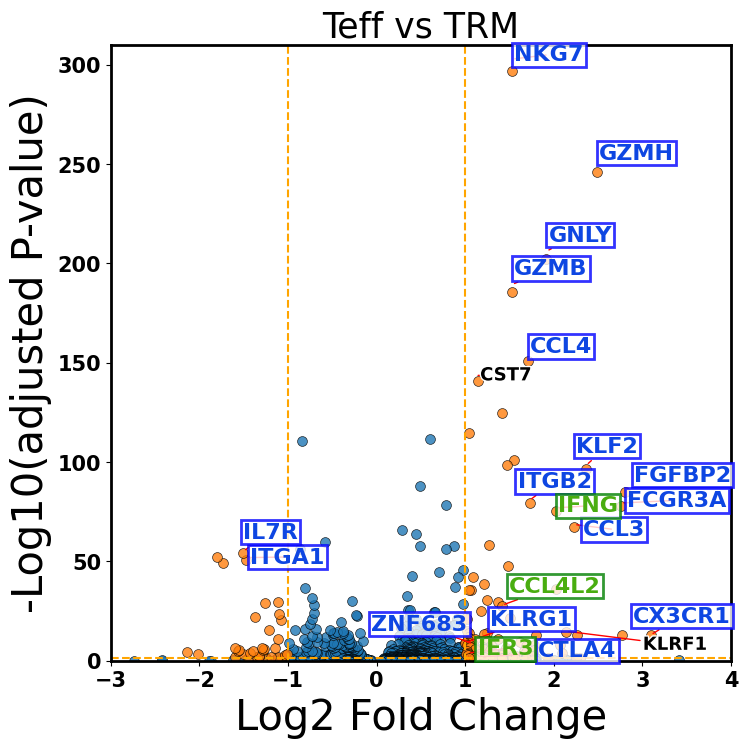

In [30]:
# Volcano plot of results
fig, ax = plt.subplots()
sb.regplot(other_de['log2fold'], other_de['-log10(Padj)'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['log2fold'], lowqval_de['-log10(Padj)'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Log2 Fold Change", fontsize=30)
ax.set_ylabel("-Log10(adjusted P-value)", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('Teff vs TRM',size = 25)
    
# Label names and positions
x = [i for i in lowqval_de['log2fold']]
y = [i*1.02 for i in lowqval_de['-log10(Padj)']]
labels = lowqval_de.index
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de.index.str.startswith('RP'))
                    |np.array(lowqval_de.index.str.startswith('MT'))
                    |np.array(lowqval_de.index.str.startswith('IG'))
                     |(np.array(lowqval_de['log2fold']<fc_thresh*2)
                       &np.array(lowqval_de['log2fold']>0)
                           &np.array(lowqval_de['-log10(Padj)']<50))
                    |(np.array(abs(lowqval_de['log2fold'])<fc_thresh*2)
                      &np.array(lowqval_de['log2fold']<0)
                           &np.array(lowqval_de['-log10(Padj)']<50))
                   |np.array(lowqval_de['-log10(Padj)']<5))==0)

texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','CCL4','CCL5','CCL3','CX3CR1','CXCR3','CXCR6']
nichenet_target = pd.read_csv('TRM2Teff_ligand_target.csv',index_col =0).values.flatten().tolist()
for i,txt in enumerate(labels):
    if txt not in important_list and txt not in nichenet_target:
        if txt in labels[to_keep]:
          if np.random.rand(1) >= 0.75:
               texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list and txt not in nichenet_target:
        texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))

for i,txt in enumerate(labels):    
    if txt in nichenet_target:
        texts.append(ax.text(x[np.where(lowqval_de.index==txt)[0][0]], y[np.where(lowqval_de.index==txt)[0][0]], txt,size = 16, color= '#49ad10', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="g", lw=2, alpha = 0.8)))

plt.ylim([-0.01,310])
plt.xlim([-3,4])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('vis/Teff vs TRM target highlight.png')
#plt.show()

In [ ]:
#From Low to High
adata_tumor = adata[adata.obs['tissue']=='Carcinoma']
sc.tl.rank_genes_groups(adata_tumor, groupby = 'activation', groups = ['low','high'], reference= 'low', key_added= 'low2high',method = 'wilcoxon')
deg_df  = get_df_from_rank(adata_tumor, rank_key='low2high',celltype='high')
deg_df_sig = deg_df[(deg_df['pval_adj']<0.05) & (abs(deg_df['log2fold'])>1)]
deg_df_sig.to_csv('low2high_deg.csv')
# deg_df_sig = deg_df[(deg_df['pval_adj']<0.05) & (deg_df['log2fold']>1)]
# deg_df_sig.to_csv('Teff2Tex_up.csv')

In [ ]:
deg_df

,log2fold,pval_adj
NKG7,2.516381,0.000000e+00
GZMB,3.392510,0.000000e+00
PRF1,2.626537,1.994480e-190
GNLY,2.431688,1.615642e-165
GZMH,3.416684,1.812134e-163
...,...,...
PABPC1,-0.489137,8.191394e-30
RGS1,-0.762729,7.701888e-30
ITGA1,-1.314216,5.550593e-31
IL7R,-1.157881,7.984060e-35
